In [1]:
# PREDICTING BICYCLE TRAFFICE:

In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression

In [11]:
counts = pd.read_csv(r'..\data\fremont_hourly.csv', index_col='Date', parse_dates=True)


In [12]:
counts.head()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 02:00:00,2.0,1.0,1.0
2012-10-03 03:00:00,5.0,2.0,3.0
2012-10-03 04:00:00,7.0,6.0,1.0


In [15]:
weather = pd.read_csv(r'..\data\SeattleWeather.csv', index_col='DATE', parse_dates=True)

In [18]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']]

In [21]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [22]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()

In [23]:
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

In [35]:
import numpy as np
from datetime import datetime

In [38]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    "Compute the hours of daylight for the given date"
    days = (date-datetime(2000, 12, 21)).days
    m = (1-np.tan(np.radians(latitude)) *np.tan(np.radians(axis)*np.cos(days*2*np.pi/365.25)))
    return 24.*np.degrees(np.arccos(1-np.clip(m, 0, 2)))/180
    

<Axes: xlabel='Date'>

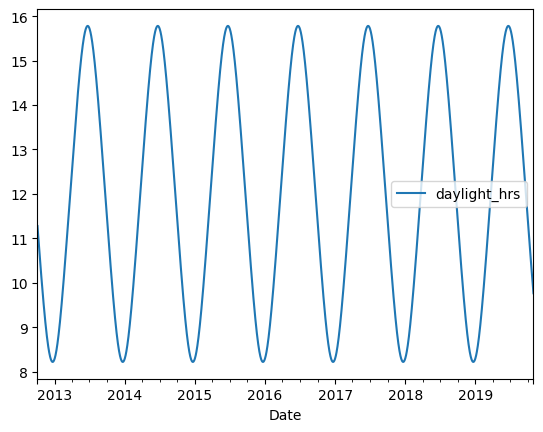

In [39]:
daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()

In [40]:
# We can also add avg temp and total prec.

In [41]:
# temps. are in 1/10 deg c; convert to c

In [42]:
weather['TMIN']/=10
weather['TMAX']/=10
weather['TEMP (C)']=0.5*(weather['TMIN'] + weather['TMAX'])

In [43]:
# precip is in 1/10 mm; convert to inches
weather['PRCP']/=254
weather['dry day']=(weather['PRCP']==0).astype(int)

In [45]:
daily = daily.join(weather[['PRCP', 'TEMP (C)', 'dry day']])

In [46]:
# now lets add a counter, that increases from day 1 and measures how many years have passed

In [47]:
daily['annual'] = (daily.index - daily.index[0]).days/365

In [48]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,TEMP (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,5.60,1,0.000000
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,5.65,1,0.002740
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,5.95,1,0.005479
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,6.05,1,0.008219
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,6.05,1,0.010959


In [51]:
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
 'daylight_hrs', 'PRCP', 'dry day', 'TEMP (C)', 'annual']

In [52]:
x = daily[column_names]
y = daily['Total']

In [54]:
model = LinearRegression(fit_intercept=False)
model.fit(x,y)
daily['predicted'] = model.predict(x)

<Axes: xlabel='Date'>

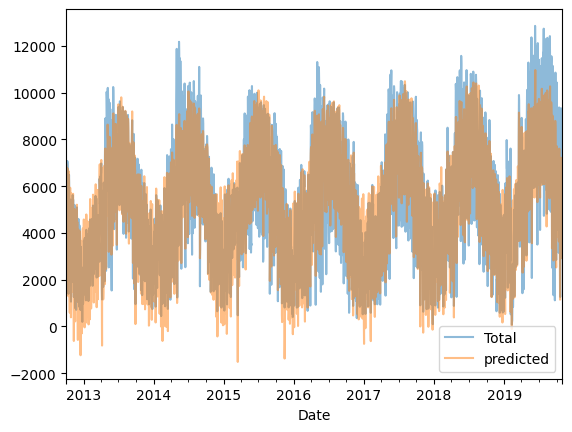

In [55]:
daily[['Total', 'predicted']].plot(alpha=0.5)

In [56]:
# Lets take a look at the coefficients of linear model to estimate how much each feature contributes to the daily bicylcle count

In [57]:
params = pd.Series(model.coef_, index=x.columns)
params

Mon              -1899.490342
Tue              -1488.728621
Wed              -1541.013404
Thu              -1815.715147
Fri              -2485.969493
Sat              -5247.430134
Sun              -5437.672854
holiday          -2221.433219
daylight_hrs       219.583029
PRCP           -360714.645502
dry day           1022.334211
TEMP (C)           885.868587
annual             141.588794
dtype: float64

In [58]:
# These numbers are difficult to interpret without some measure of their uncertainity

In [59]:
from sklearn.utils import resample
np.random.seed(1)

In [60]:
err = np.std([model.fit(*resample(x,y)).coef_ for i in range(1000)], 0)

In [61]:
# With these error estimates, lets again look at the results

In [62]:
print(pd.DataFrame({'effect':params.round(0),
                    'error': err.round(0)}))

                effect    error
Mon            -1899.0    142.0
Tue            -1489.0    140.0
Wed            -1541.0    137.0
Thu            -1816.0    138.0
Fri            -2486.0    136.0
Sat            -5247.0    135.0
Sun            -5438.0    138.0
holiday        -2221.0    300.0
daylight_hrs     220.0     14.0
PRCP         -360715.0  23542.0
dry day         1022.0     51.0
TEMP (C)         886.0     36.0
annual           142.0     11.0
